# Poker Parser

- luck: number won at showdown 

### Import functions

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
import parser_script

def find(s, ch):
    return np.array([i for i, ltr in enumerate(s) if ltr == ch]).astype(int)

### Load and process data

In [21]:
dfraw = pd.read_csv('../data/data_03_12_20.csv').reset_index(drop=True)
df = dfraw[dfraw['entry'].str.contains('Player stacks')].reset_index(drop=False)
df = df.rename(columns={'index':'original_index'})
df = df.drop(columns={'order'})

df = df[::-1].reset_index(drop=True)

In [30]:
df = parser_script.get_robust_totals(dfraw, names)

AssertionError: 

In [22]:
# Get names

for irow in range(len(df)):
    s = df.loc[irow,'entry']
    name_starts = find(s,'"')[::2]+1
    name_ends   = find(s,'@')-1
    num_starts  = find(s,'(')+1
    num_ends    = find(s,')')
    for iname in range(len(name_starts)):
        name = s[name_starts[iname]:name_ends[iname]]
        num  = s[num_starts[iname]:num_ends[iname]]
        df.loc[irow,name] = float(num)

names = [n for n in df.columns if n not in ['entry','at','order','original_index']]

In [23]:
for n in names:
    df[n+'_buybacks'] = 0
    df[n+'_buyback_total'] = 0

### Account for buy-backs

In [24]:
buyback_rows = dfraw[dfraw['entry'].str.contains('joined')].reset_index(drop=False)
buyback_rows = buyback_rows.rename(columns={'index':'original_index'})[:-len(names)]

for i in list(range(len(buyback_rows)))[::-1]:
    etr = buyback_rows.loc[i,'entry']
    name = etr[etr.index('"')+1:etr.index('@')-1]
    num = etr[etr.index('of')+3:-1]
    at = buyback_rows.loc[i,'at'].replace('T',' ')
    time = at[at.index(':')-2:at.index(':')+3]
    yn = 0
    while yn not in ['y','n']:
        yn = input(f'Did {name} buy back in for {num} at {time}? [y/n] ')
    buyback_rows.loc[i,'is_buyback'] = (yn=='y')
    buyback_rows.loc[i,'amount'] = float(num)
    buyback_rows.loc[i,'name'] = name

Did Dr. Hurst buy back in for 2.35 at 20:47? [y/n]  n
Did Dr. Hurst buy back in for 3.50 at 21:30? [y/n]  y


In [25]:
# Necessary. If you go all in, then buy back for less than you went all-in for, 
# I don't think there's a way of distinguishing it from losing the difference
# and then sitting out a round.

for i in range(len(buyback_rows)):
    if not buyback_rows.loc[i,'is_buyback']:
        continue
    # < since we have inverted df 
    ind = buyback_rows.loc[i,'original_index']
    amount = buyback_rows.loc[i,'amount']
    name = buyback_rows.loc[i,'name']

    df.loc[df['original_index']<ind, name] -= amount
    df.loc[df['original_index']<ind, name+'_buybacks'] += 1
    df.loc[df['original_index']<ind, name+'_buyback_total'] += amount

In [26]:
for nam in names:
    nanrows = df[pd.isnull(df[nam])]
    nanrows = nanrows.loc[[ind for ind in nanrows.index if ind-1 not in nanrows.index]]
    for i_n in range(len(nanrows)):
        index_of_row = nanrows.iloc[[i_n]].index[0]
        inbb = nanrows.loc[index_of_row, name+'_buybacks']
        for i_df in range(index_of_row, len(df)):
            if not np.isnan(df.loc[i_df, name]):
                if df.loc[i_df, name+'_buybacks'] == inbb+1:
                    inds_to_fill = list(range(index_of_row,i_df+1))
                    df.loc[inds_to_fill, name] = -nanrows.loc[index_of_row, name+'_buyback_total']
                break
        else:
            inds_to_fill = list(range(index_of_row,len(df)))
            df.loc[inds_to_fill, name] = -nanrows.loc[index_of_row, name+'_buyback_total']

In [27]:
df = df.ffill()

# Not inds that have no change = some error in accounting
inds_to_keep = [0] 
for i in range(1, len(df)):
    for nam in names:
        if df.loc[i, nam]!=df.loc[i-1, nam]:
            inds_to_keep.append(i)
            break
df = df.loc[inds_to_keep, names+['at']].reset_index(drop=True)

### Colour tester

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)] 



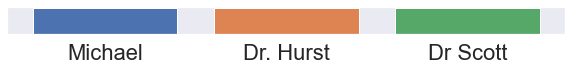

In [28]:
from matplotlib import colors as mcolors
cols = list(mcolors.CSS4_COLORS.keys())
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
cols = [c for c in cols if 'white' not in c]
#np.random.shuffle(cols)

# Suggested colour scheme. Comment this line out to try random schemes.
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise','grey']

plt.figure(figsize=[10,0.5])
for i,n in enumerate(names):
    plt.bar([names[i]], [1], color=cols[i])
    plt.xticks(rotation=0);
    plt.yticks([]);
print(cols[:len(names)], '\n')

# Some good colour schemes
# cols = ['mediumturquoise', 'grey', 'red', 'darkmagenta']
# cols = ['forestgreen', 'orange', 'purple', 'cornflowerblue']
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise']

### Plot total bankroll over time

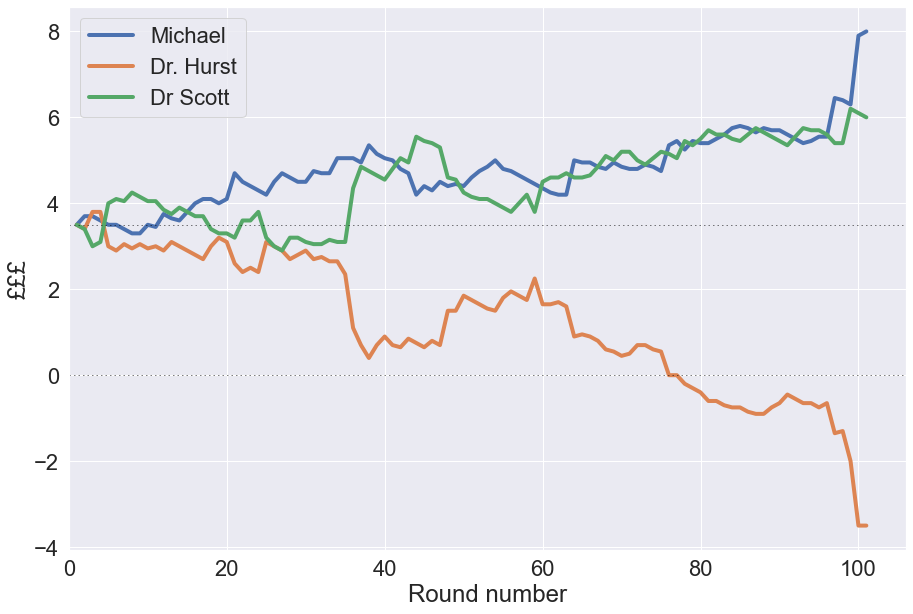

In [29]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)
for i,n in enumerate(names):
    plt.plot(np.arange(1,len(df)+1),df[n].values,label=n,color=cols[i],linewidth=4)
plt.legend()
plt.xlabel('Round number')
plt.ylabel('£££')
plt.xlim(left=0);
plt.gca().axhline(0,dashes=[3,6],linewidth=.5,color='black')
plt.gca().axhline(df.loc[0,names[0]],dashes=[3,6],linewidth=.5,color='black')

#plt.savefig(f'poker_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')

### Plot winnings and losses per round

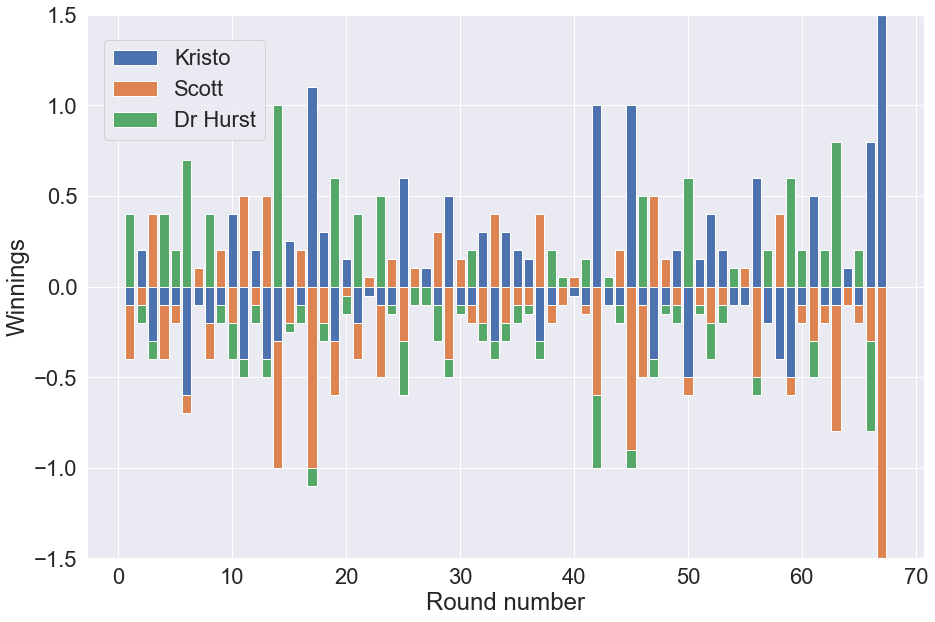

In [24]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)

previous = (np.arange(1,len(df))*0).astype(float)
for i,n in enumerate(names):
    diffs = np.diff(df[n])

    above_part = np.where(diffs>0, diffs, 0)
    plt.bar(np.arange(1,len(df)),above_part,color=cols[i], label=n, alpha=1)

    bottom_part = np.diff(df[n])
    bottom_part = np.where(diffs<0, -diffs, 0)
    previous-=bottom_part

    inds = np.where(bottom_part!=0)[0]
    y_plot = bottom_part[inds]
    x_plot = np.arange(1,len(df))[inds] 
    plt.bar(x_plot,y_plot,bottom=previous[inds],color=cols[i], alpha=1)


plt.legend(loc=[0.02,.77])
plt.xlabel('Round number')
plt.ylabel('Winnings')
range_ = 1.5

plt.ylim((-range_,range_));

#plt.savefig(f'winnings_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')

### Who won at which parts?

In [25]:
entries = dfraw['entry'][::-1]

all_hands = []
hand = []
active = 0
for i,e in enumerate(entries):
    if active and '--' not in e:
        hand.append(e)
    if '-- starting hand' in e:
        starter = i
        active = 1
    if '-- ending hand' in e:
        active = 0
        all_hands.append(hand)
        hand = []

In [26]:
def get_winner(hand,names):
    for row in hand:
        if 'collected' in row:
            for n in names:
                if n in row:
                    return n

def get_section(hand):
    for sec in ['River','Turn','Flop']:
        if sec in ' '.join(hand):
            return sec
    return 'Preflop'

In [27]:
win_on = pd.DataFrame({
    'Name':names,
    'Preflop':[0]*len(names),
    'Flop':[0]*len(names),
    'Turn':[0]*len(names),
    'River':[0]*len(names),
})

win_on = win_on.set_index('Name')

for h in all_hands:
    winner  = get_winner(h,names)
    section = get_section(h)
    win_on.loc[winner,section] += 1

win_on = win_on.reset_index(drop=False)

In [28]:
def bar_plotter(df, save=True, perc=False):
    plt.figure(figsize=(10,5))
    sns.set(font_scale=2)
    
    rounds = [c for c in df.columns if c!='Name']
    names = list(df['Name'].values)
    
    main_ticks = np.arange(len(rounds))
    jump = 1/(len(names)+1)
    
    for i, n in enumerate(names):
        xpos = main_ticks + jump*i
        
        data_to_plot = [df.loc[df['Name']==n, r].values[0] for r in rounds]
        
        plt.bar(
            xpos,
            data_to_plot,
            width=jump*0.9,
            label=n.title(),
            color=cols[i]
        )
        
    if perc:
        plt.ylabel('Percentage rounds won for player')
    else:
        plt.ylabel('Rounds won')
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    plt.gca().set_xticklabels(rounds)
    legend = plt.legend(title='Player', loc=[0.98,0.6])
    plt.setp(legend.get_title(),fontsize=15)
    plt.grid(axis='x')
    if save:
        if perc:
            plt.savefig(f'percrounds_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')
        else:
            plt.savefig(f'rounds_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')
    plt.show()

In [29]:
win_on_perc = win_on.copy()[['Preflop','Flop','Turn','River']]
totals = win_on_perc.sum(axis=1)
for i in range(len(win_on_perc)):
    win_on_perc.loc[i,:] = 100*win_on_perc.loc[i,:]/totals[i]
win_on_perc['Name'] = names

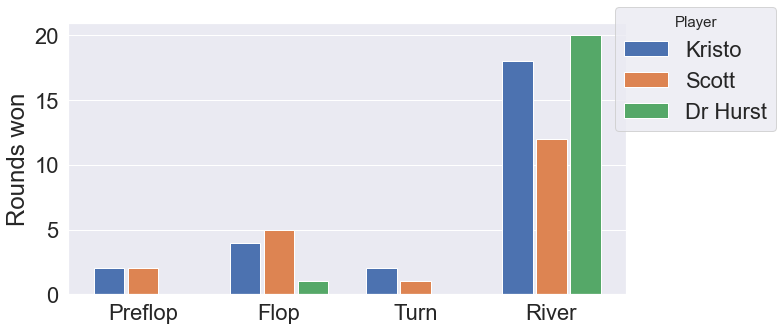

In [30]:
bar_plotter(win_on, save=True)

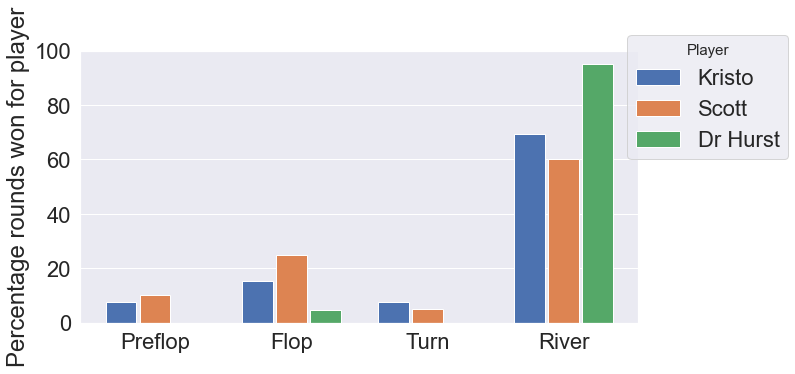

In [31]:
bar_plotter(win_on_perc, save=True, perc=True)

In [20]:
megfold = 0
scottfold = 0

In [21]:
dfraw = dfraw.reset_index(drop=1)

In [22]:
for i in range(len(dfraw)):
    entry = dfraw.loc[i,'entry']
    if 'Meg' in entry and 'fold' in entry:
        megfold +=1
    if 'Scott' in entry and 'fold' in entry:
        scottfold +=1

In [65]:
df[(df.Meg==10)&(df.Scott==10)]

,Meg,Scott,at
0,10.0,10.0,2021-02-06T10:04:06.617Z
36,10.0,10.0,2021-02-06T11:04:26.669Z
45,10.0,10.0,2021-02-06T11:15:34.354Z
67,10.0,10.0,2021-02-06T11:36:48.058Z
73,10.0,10.0,2021-02-06T11:42:09.910Z


In [72]:
df0 = df[0:36]
df1 = df[36:45]
df2 = df[45:67]
df3 = df[67:73]
df4 = df[73:]

In [69]:
df0 = df0.append(pd.DataFrame({'Meg':0,'Scott':20,'at':''}))

,Meg,Scott,at
67,10.0,10.0,2021-02-06T11:36:48.058Z
68,10.4,9.6,2021-02-06T11:37:55.260Z
69,10.6,9.4,2021-02-06T11:38:36.042Z
70,10.4,9.6,2021-02-06T11:39:13.446Z
71,10.8,9.2,2021-02-06T11:39:59.004Z
72,11.8,8.2,2021-02-06T11:40:47.831Z


In [74]:
df1

,Meg,Scott,at
36,10.0,10.0,2021-02-06T11:04:26.669Z
37,10.6,9.4,2021-02-06T11:05:48.119Z
38,10.8,9.2,2021-02-06T11:06:40.658Z
39,10.2,9.8,2021-02-06T11:08:00.422Z
40,10.4,9.6,2021-02-06T11:09:14.600Z
41,10.8,9.2,2021-02-06T11:10:03.397Z
42,11.6,8.4,2021-02-06T11:11:57.066Z
43,11.8,8.2,2021-02-06T11:12:36.551Z
44,11.4,8.6,2021-02-06T11:13:21.194Z


# Robust method

In [36]:
def df_gn(dfraw, x):
    dfraw_inv = dfraw[::-1]
    i=0
    while True:
        dfnext = dfraw_inv[i:i+x]
        i+=x
        yield dfnext

In [95]:
import re

match = 

In [96]:
match

['0.70', '4.32']

In [39]:
import re

def get_robust_totals(dfraw, names):
    dfi = dfraw[::-1].reset_index(drop=True)
    starts = dfi[dfi.entry.str.contains('-- starting hand')]
    ends   = dfi[dfi.entry.str.contains('-- ending hand')]
    starts = starts[:len(ends)]
    hands = []

    for i in range(len(starts)):
        hands.append(dfi.loc[starts.index[i]:ends.index[i]])
        
    

def get_hand_differential(hand, names):
    hand_diff = {n:0 for n in names}
    
    hand_text_all = ' '.join(hand.entry.values)
    indices = [hand[hand.entry.str.contains(x)].index[0] for x in ['Your hand','Flop','Turn','River'] if x in hand_text_all]
    indices.append(hand.index[-1])
    rounds = [hand.loc[indices[i]:indices[i+1]-1] for i in range(len(indices)-1)]
    
    for rnd in rounds:
        round_diff = get_round_differential(rnd, names)
        for n in names:
            hand_diff[n] += round_diff[n]

    return hand_diff
        
def get_number(string):
    num = re.findall(r'\d+\.\d*', row)
    assert len(num)==1
    return num[0]
        
def get_round_differential(rnd, names)
    betting_signatures = ['calls','checks','bets','posts']
    taking_signatures = ['returned', 'collected']
    
    diff = {n:0 for n in names}
    
    for i,row in rnd.iterrows():
        text = row['entry']
        
        if 'bets' in text or 'posts' in text:
            diff[which_player(text,names)] -= get_number(text)
            
        elif 'calls' in text:
            diff[which_player(text,names)] = 0-get_number(text)
            
        elif 'returned' in text or 'collected' in text:
            diff[which_player(text,names)] += get_number(text)
        
    return diff           

def which_player(entry, names):
    for n in names:
        if n in entry:
            return n
    return None

def apply_rebuys(df, names):
    pass

In [35]:
dfi = dfraw[::-1].reset_index(drop=True)
starts = dfi[dfi.entry.str.contains('-- starting hand')]
ends   = dfi[dfi.entry.str.contains('-- ending hand')]
starts = starts[:len(ends)]
hands = []

for i in range(len(starts)):
    hands.append(dfi.loc[starts.index[i]:ends.index[i]])

In [36]:
hand = hands[2]

In [37]:
hand

,entry,at,order
56,-- starting hand #3 (No Limit Texas Hold'em) ...,2020-12-03T20:17:50.223Z,160702667022400
57,"Player stacks: #1 ""Michael @ Fer4N75h9y"" (3.70...",2020-12-03T20:17:50.223Z,160702667022401
58,"Your hand is J♥, 10♥",2020-12-03T20:17:50.223Z,160702667022404
59,"""Dr Scott @ Ce3DFmEur5"" posts a small blind of...",2020-12-03T20:17:50.223Z,160702667022405
60,"""Michael @ Fer4N75h9y"" posts a big blind of 0.10",2020-12-03T20:17:50.223Z,160702667022406
61,"""Dr. Hurst @ b7rmnGbpoR"" folds",2020-12-03T20:17:53.330Z,160702667333100
62,"""Dr Scott @ Ce3DFmEur5"" calls 0.10",2020-12-03T20:17:55.508Z,160702667550900
63,"""Michael @ Fer4N75h9y"" checks",2020-12-03T20:17:57.390Z,160702667739000
64,"flop: [K♥, A♣, Q♣]",2020-12-03T20:17:58.198Z,160702667820000
65,"""Dr Scott @ Ce3DFmEur5"" bets 0.10",2020-12-03T20:18:02.280Z,160702668228300


In [59]:
rounds[0]

,entry,at,order
64,"Your hand is 5♦, 2♦",2021-02-11T20:15:43.333Z,161307454333503
65,"""Dr Hurst @ b7rmnGbpoR"" posts a small blind of...",2021-02-11T20:15:43.333Z,161307454333505
66,"""Kristo @ byVXgubSAR"" posts a big blind of 0.10",2021-02-11T20:15:43.333Z,161307454333506
67,"""Scott @ Ce3DFmEur5"" calls 0.10",2021-02-11T20:15:52.653Z,161307455265400
68,"""Dr Hurst @ b7rmnGbpoR"" calls 0.10",2021-02-11T20:15:56.121Z,161307455612200
69,"""Kristo @ byVXgubSAR"" checks",2021-02-11T20:16:00.275Z,161307456027600


In [45]:
hand.entry.str.lower().str.startswith('.')

56    False
57    False
58    False
59    False
60    False
61    False
62    False
63    False
64    False
65    False
66    False
67    False
68    False
69    False
Name: entry, dtype: bool